In [1]:
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline





In [2]:
import nbodykit.lab as nb
import readgadget
import MAS_library as MASL
from tqdm import tqdm
from nbodykit.source.catalog.file import BigFileCatalog
import numpy as np



In [3]:
test_LH_id = 3


In [4]:
ptypes       = [1]
grids         = [128]
BoxSize = 1000.0 #Mpc/h ; size of box
# snap_num_array = [4, 3]
snapnum = 3
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapdir = snap_dir_base + '/' + str(test_LH_id)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth_orig = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth_orig = rockstar[:,index_M]  #Halo masses in Msun/h
lgmass_truth_orig = np.log10(mass_truth_orig)

vel_h_truth_orig = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel_truth = np.where(lgmass_truth_orig>13)[0]

pos_h_truth_orig = pos_h_truth_orig[indsel_truth]
vel_h_truth_orig = vel_h_truth_orig[indsel_truth]
lgmass_truth_orig = lgmass_truth_orig[indsel_truth]


/tmp/ipykernel_295411/1197252509.py:16: RuntimeWarning: divide by zero encountered in log10
  lgmass_truth_orig = np.log10(mass_truth_orig)


In [5]:
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/latin_hypercube_HR/'
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,test_LH_id,snapnum,snapnum)
ptypes       = [1]
BoxSize = 1000.0 #Mpc/h ; size of box
ppos_orig = readgadget.read_block(snapshot, "POS ", ptypes)/1e3 #positions in Mpc/h
pvel_orig = readgadget.read_block(snapshot, "VEL ", ptypes) #positions in Mpc/h





In [56]:
# import torch
from scipy.interpolate import RegularGridInterpolator

MAS = 'CIC'
# gridv = 256
# gridv = 384
gridv = 1024
# gridv = 512

xall = (np.linspace(0, 1000, gridv + 1))
xarray = 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)

mesh_rhov_orig = np.zeros((gridv, gridv, gridv), dtype=np.float32)
MASL.MA(ppos_orig.astype(np.float32), mesh_rhov_orig, BoxSize, MAS)

mesh_momx_orig = np.zeros((gridv, gridv, gridv), dtype=np.float32)
MASL.MA(ppos_orig.astype(np.float32), mesh_momx_orig, BoxSize, MAS, W=pvel_orig[:,0].astype(np.float32))
mesh_velx_orig = mesh_momx_orig/mesh_rhov_orig
interpvx_orig = RegularGridInterpolator((xarray, yarray, zarray), mesh_velx_orig, bounds_error=False, fill_value=None)
velx_query_interp_orig = interpvx_orig(np.array(pos_h_truth_orig))


mesh_momy_orig = np.zeros((gridv, gridv, gridv), dtype=np.float32)
MASL.MA(ppos_orig.astype(np.float32), mesh_momy_orig, BoxSize, MAS, W=pvel_orig[:,1].astype(np.float32))
mesh_vely_orig = mesh_momy_orig/mesh_rhov_orig
interpvy_orig = RegularGridInterpolator((xarray, yarray, zarray), mesh_vely_orig, bounds_error=False, fill_value=None)
vely_query_interp_orig = interpvy_orig(np.array(pos_h_truth_orig))

mesh_momz_orig = np.zeros((gridv, gridv, gridv), dtype=np.float32)
MASL.MA(ppos_orig.astype(np.float32), mesh_momz_orig, BoxSize, MAS, W=pvel_orig[:,2].astype(np.float32))
mesh_velz_orig = mesh_momz_orig/mesh_rhov_orig
interpvz_orig = RegularGridInterpolator((xarray, yarray, zarray), mesh_velz_orig, bounds_error=False, fill_value=None)
velz_query_interp_orig = interpvz_orig(np.array(pos_h_truth_orig))







/tmp/ipykernel_295411/3513114157.py:20: RuntimeWarning: invalid value encountered in true_divide
  mesh_velx_orig = mesh_momx_orig/mesh_rhov_orig
/tmp/ipykernel_295411/3513114157.py:27: RuntimeWarning: invalid value encountered in true_divide
  mesh_vely_orig = mesh_momy_orig/mesh_rhov_orig
/tmp/ipykernel_295411/3513114157.py:33: RuntimeWarning: invalid value encountered in true_divide
  mesh_velz_orig = mesh_momz_orig/mesh_rhov_orig


In [57]:
# np.amin(mesh_rhov_orig)
# np.amin(pvel_orig[:,0]),np.amin(pvel_orig[:,1]),np.amin(pvel_orig[:,2])
np.all(np.isfinite(velx_query_interp_orig))



False

In [62]:
vel_query_interp_orig = np.vstack((velx_query_interp_orig, vely_query_interp_orig, velz_query_interp_orig)).T




Text(0, 0.5, 'velocity truth')

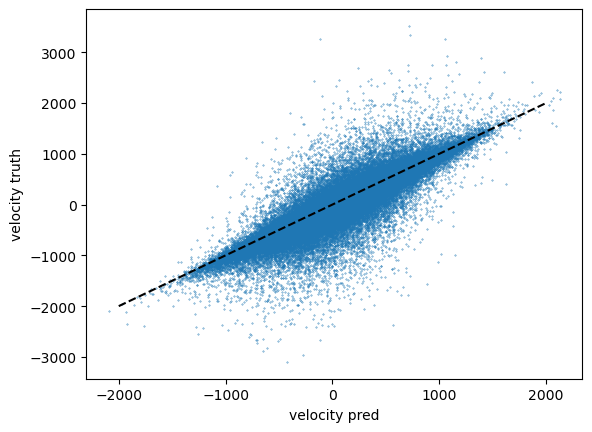

In [59]:
pl.figure()
pl.scatter(vel_query_interp_orig[:,0], vel_h_truth_orig[:,0], s=0.1)
pl.plot([-2000,2000], [-2000,2000], 'k--')
pl.xlabel('velocity pred')
pl.ylabel('velocity truth')


In [60]:
np.corrcoef(vel_query_interp_orig[:,0], vel_h_truth_orig[:,0])
# vel_query_interp_orig[:,0]
# ind_nan = np.isinf(vel_query_interp_orig[:,0])




array([[nan, nan],
       [nan,  1.]])

In [61]:
vel_query_interp_orig -= np.mean(vel_query_interp_orig, axis=0)


In [54]:
# vmock_pred_interp -= np.mean(vmock_pred_interp, axis=0)
# vmock_pred_interp_allfinite -= np.mean(vmock_pred_interp_allfinite, axis=0)


Text(0.5, 1.0, 'Histogram; vel grid=1024')

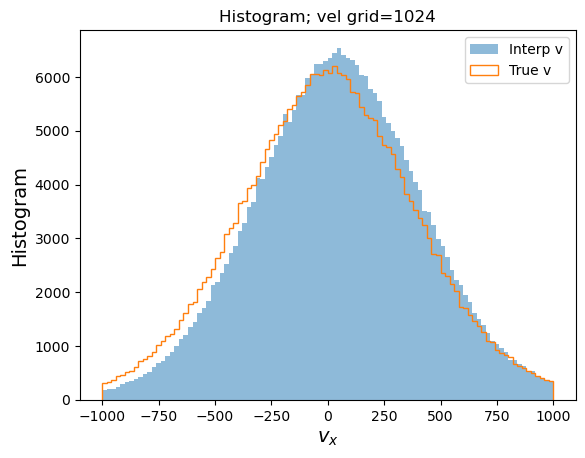

In [63]:
# vmock_pred.shape
pl.figure()
# _ = pl.hist(vmock_pred[:,0], bins=100, alpha=0.5, label='pred', range=(-1000,1000))
# _ = pl.hist(vel_h_truth_orig[:,0], bins=100, alpha=0.5, label='truth', histtype='step', range=(-1000,1000))

# _ = pl.hist(vmock_pred[:,1], bins=100, alpha=0.5, label='pred', range=(-1000,1000))
# _ = pl.hist(vmock_pred_interp[:,1], bins=100, alpha=0.5, label='pred', range=(-1000,1000))
_ = pl.hist(vel_query_interp_orig[:,0], bins=100, alpha=0.5,  range=(-1000,1000), label='Interp v')
_ = pl.hist(vel_h_truth_orig[:,0], bins=100, alpha=1.0, histtype='step', range=(-1000,1000), label='True v')
pl.xlabel(r'$v_x$', size=14)
pl.ylabel('Histogram', size=14)
pl.legend()
pl.title(f'Histogram; vel grid={gridv}')




In [64]:
redshift = 0.5
LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt'
LH_cosmo_val_all = np.loadtxt(LH_cosmo_val_file)
from colossus.cosmology import cosmology
cosmo_LH = LH_cosmo_val_all[test_LH_id]
params_LH = {'flat': True, 'H0': 100*cosmo_LH[2], 'Om0': cosmo_LH[0], 'Ob0': cosmo_LH[1], 'sigma8': cosmo_LH[4], 'ns': cosmo_LH[3]}
cosmo_LH = cosmology.setCosmology('myCosmo', **params_LH)

import redshift_space_library as RSL
# hpos_mock_z = np.copy(hpos_mock).astype(np.float32)
# vmock_pred = np.copy(vmock_pred).astype(np.float32)

# hpos_mock_z = np.ascontiguousarray(hpos_mock, dtype=np.float32)
# vmock_pred = np.ascontiguousarray(vmock_pred, dtype=np.float32)

# RSL.pos_redshift_space(hpos_mock_z, vmock_pred, BoxSize, cosmo_LH.Hz(redshift), 0.5, axis=0)



In [65]:
hpos_truth_z = np.ascontiguousarray(pos_h_truth_orig, dtype=np.float32)
vel_h_truth_z = np.ascontiguousarray(vel_h_truth_orig, dtype=np.float32)

RSL.pos_redshift_space(hpos_truth_z, vel_h_truth_z, BoxSize, cosmo_LH.Hz(redshift), 0.5, axis=0)



In [66]:
hpos_truth_z_interpv = np.ascontiguousarray(pos_h_truth_orig, dtype=np.float32)
vmock_pred_interp_pos_orig = np.ascontiguousarray(vel_query_interp_orig, dtype=np.float32)

RSL.pos_redshift_space(hpos_truth_z_interpv, vmock_pred_interp_pos_orig, BoxSize, cosmo_LH.Hz(redshift), 0.5, axis=0)




In [67]:
import Pk_library as PKL
import MAS_library as MASL
grid = 128
# MAS = 'NGP'
MAS = 'NGP'
Mmin_Pk, Mmax_Pk = 13.0, 16.0
# indsel_Pk_truth = np.where((lgmass_truth_orig > Mmin_Pk) & (lgmass_truth_orig < Mmax_Pk))[0]
# print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
# shot_noise_truth2 = BoxSize**3/len(indsel_Pk_truth)
# mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
# pos_truth2 = (pos_h_truth_orig[indsel_Pk_truth,...]).astype(np.float32)
# MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
# mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
# # Pk_truth2_realspace = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)
# Pk_truth2_realspace = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=MAS, threads=1)


# # Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
# indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
# print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
# mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
# pos_mock = (hpos_mock[indsel_Pk_mock,...]).astype(np.float32)
# MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
# mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
# # Pk_mock_realspace = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)  
# Pk_mock_realspace = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=MAS, threads=1)  




In [68]:
import Pk_library as PKL
import MAS_library as MASL
grid = 128
MAS = 'NGP'
Mmin_Pk, Mmax_Pk = 13.0, 16.0
indsel_Pk_truth = np.where((lgmass_truth_orig > Mmin_Pk) & (lgmass_truth_orig < Mmax_Pk))[0]
print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
shot_noise_truth2 = BoxSize**3/len(indsel_Pk_truth)
mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (hpos_truth_z[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
# Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=MAS, threads=1)


Mmin_Pk, Mmax_Pk = 13.0, 16.0
indsel_Pk_truth = np.where((lgmass_truth_orig > Mmin_Pk) & (lgmass_truth_orig < Mmax_Pk))[0]
print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
shot_noise_truth3 = BoxSize**3/len(indsel_Pk_truth)
mesh_truth3 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth3 = (hpos_truth_z_interpv[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth3, mesh_truth3, BoxSize, MAS)
mesh_truth3 /= np.mean(mesh_truth3, dtype=np.float32);  mesh_truth3 -= 1.0
# Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)
Pk_truth3 = PKL.Pk(mesh_truth3, BoxSize, axis=0, MAS=MAS, threads=1)


# Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
# indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
# print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
# mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
# pos_mock = (hpos_mock_z[indsel_Pk_mock,...]).astype(np.float32)
# MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
# mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
# # Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)  
# Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=MAS, threads=1)  

# indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
# print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
# mesh_mock2 = np.zeros((grid, grid, grid), dtype=np.float32)
# pos_mock2 = (hpos_mock_z2[indsel_Pk_mock,...]).astype(np.float32)
# MASL.MA(pos_mock2, mesh_mock2, BoxSize, MAS)
# mesh_mock2 /= np.mean(mesh_mock2, dtype=np.float32);  mesh_mock2 -= 1.0
# # Pk_mock2 = PKL.Pk(mesh_mock2, BoxSize, axis=0, MAS=None, threads=1)  
# Pk_mock2 = PKL.Pk(mesh_mock2, BoxSize, axis=0, MAS=MAS, threads=1)  




13.0 16.0 , number in truth:, 295475

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.09 seconds
13.0 16.0 , number in truth:, 295475

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.09 seconds


In [69]:
# pl.figure()
# pl.plot(Pk_mock.k3D, Pk_mock_realspace.Pk[:,0], label='mock')
# pl.plot(Pk_truth2.k3D, Pk_truth2_realspace.Pk[:,0], label='truth')

# pl.loglog()
# # pl.loglog()
# pl.legend()
# pl.ylabel(r'$P(k)$', size=14)
# pl.xlabel(r'$k$', size=14)
# pl.title(r'Real space; NGP deconvolved')



In [70]:
# pl.figure()
# # pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='mock')
# pl.plot(Pk_mock2.k3D, Pk_mock2.Pk[:,0], label='mock', ls='-')
# pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='truth')
# # pl.plot(Pk_mock2.k3D, Pk_mock2.Pk[:,0], label='mock2', ls='--')
# pl.loglog()
# pl.legend()
# pl.ylabel(r'$P_{\ell = 0}(k)$', size=14)
# pl.xlabel(r'$k$', size=14)
# pl.title(r'Monopole; NGP deconvolved')



Text(0.5, 1.0, 'Monopole; vel grid=1024')

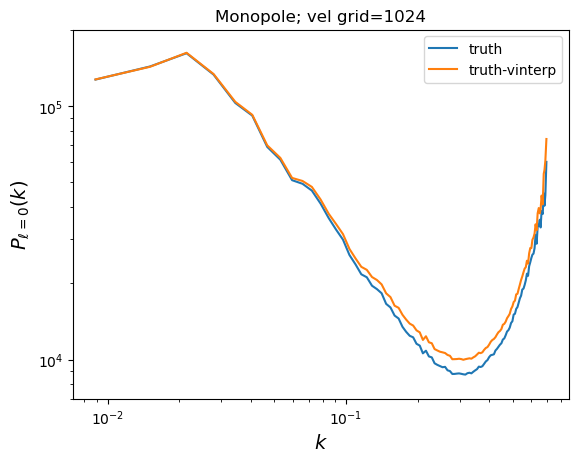

In [71]:
pl.figure()
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='mock')
# pl.plot(Pk_mock2.k3D, Pk_mock2.Pk[:,0], label='mock', ls='-')
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='truth')
pl.plot(Pk_truth3.k3D, Pk_truth3.Pk[:,0], label='truth-vinterp')
# pl.plot(Pk_mock2.k3D, Pk_mock2.Pk[:,0], label='mock2', ls='--')
pl.loglog()
pl.legend()
pl.ylim(7e3,2e5)
pl.ylabel(r'$P_{\ell = 0}(k)$', size=14)
pl.xlabel(r'$k$', size=14)
pl.title(f'Monopole; vel grid={gridv}')



(1000.0, 200000.0)

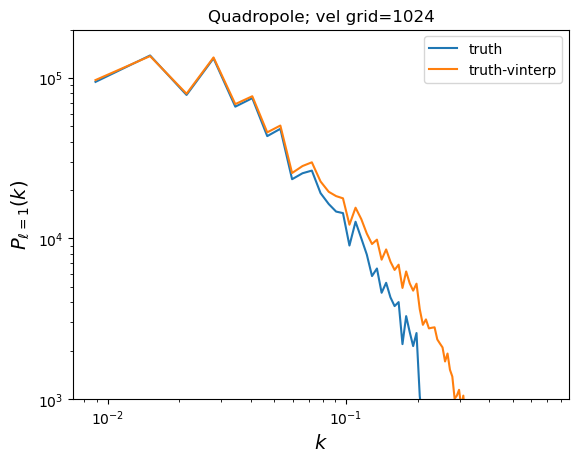

In [72]:
pl.figure()
# pl.plot(Pk_mock.k3D, Pk_mock2.Pk[:,1], label='mock', ls='-')
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,1], label='truth')
pl.plot(Pk_truth3.k3D, Pk_truth3.Pk[:,1], label='truth-vinterp')
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,1], label='mock')
# pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,1], label='mock')
# pl.plot(Pk_mock.k3D, Pk_mock2.Pk[:,1], label='mock2', ls='--')
pl.loglog()
pl.legend()
pl.ylabel(r'$P_{\ell = 1}(k)$', size=14)
pl.xlabel(r'$k$', size=14)
# pl.title(r'Quadropole; NGP deconvolved')
pl.title(f'Quadropole; vel grid={gridv}')
pl.ylim(1e3,2e5)



Text(0.5, 1.0, 'Hexadecapole; NGP deconvolved')

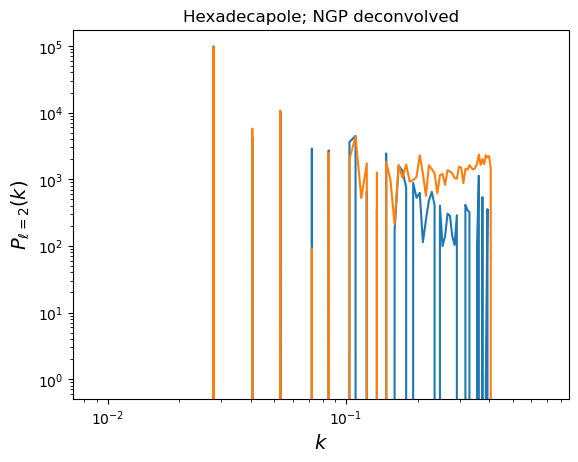

In [43]:
pl.figure()
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,2], label='mock')
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,2], label='truth')

pl.loglog()
pl.ylabel(r'$P_{\ell = 2}(k)$', size=14)
pl.xlabel(r'$k$', size=14)
pl.title(r'Hexadecapole; NGP deconvolved')



In [44]:
import Pk_library as PKL
import MAS_library as MASL
grid = 128
MAS = 'CIC'
Mmin_Pk, Mmax_Pk = 13.0, 16.0
indsel_Pk_truth = np.where((lgmass_truth_orig > Mmin_Pk) & (lgmass_truth_orig < Mmax_Pk))[0]
print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
shot_noise_truth2 = BoxSize**3/len(indsel_Pk_truth)
mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (hpos_truth_z[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)


# Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
pos_mock = (hpos_mock_z[indsel_Pk_mock,...]).astype(np.float32)
MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)  

indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
mesh_mock2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_mock2 = (hpos_mock_z2[indsel_Pk_mock,...]).astype(np.float32)
MASL.MA(pos_mock2, mesh_mock2, BoxSize, MAS)
mesh_mock2 /= np.mean(mesh_mock2, dtype=np.float32);  mesh_mock2 -= 1.0
Pk_mock2 = PKL.Pk(mesh_mock2, BoxSize, axis=0, MAS=None, threads=1)  




13.0 16.0 , number in truth:, 295475

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds
13.0 16.0  number in mock:, 301743

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds
13.0 16.0  number in mock:, 301743

Computing power spectrum of the field...
Time to complete loop = 0.06
Time taken = 0.08 seconds


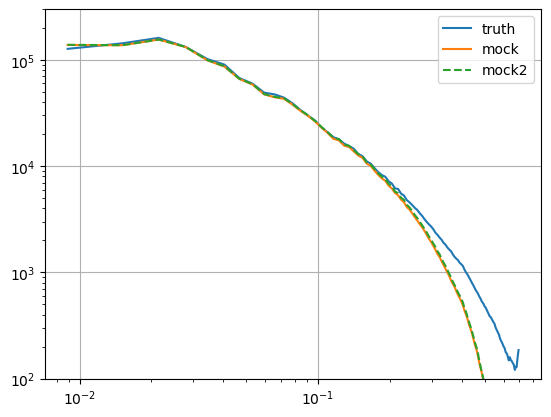

In [45]:
pl.figure()
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='truth')
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,0], label='mock')
pl.plot(Pk_mock2.k3D, Pk_mock2.Pk[:,0], label='mock2', ls='--')
pl.loglog()
pl.legend()
pl.ylim(1e2, 3e5)
pl.grid()


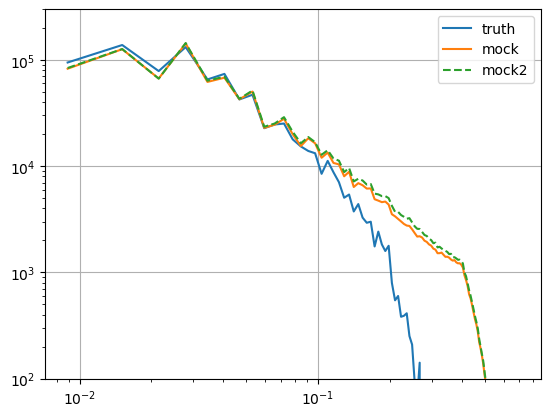

In [46]:
pl.figure()
pl.plot(Pk_truth2.k3D, Pk_truth2.Pk[:,1], label='truth')
pl.plot(Pk_mock.k3D, Pk_mock.Pk[:,1], label='mock')
pl.plot(Pk_mock2.k3D, Pk_mock2.Pk[:,1], label='mock2', ls='--')
pl.loglog()
pl.legend()
pl.ylim(1e2, 3e5)
pl.grid()


